In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


img_size = 28
mnist_data = pd.read_csv('./mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]      # DATA: raw digits data

In [ ]:
# Visually sampling the data

img_size = 28
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digits))
    plt.imshow(digits[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Resizing

In [2]:
import cv2


digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

# print('Digits resized', np.shape(digitsResized))

In [ ]:
# Visually sampling the data

img_size = 14
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digitsResized))
    plt.imshow(digitsResized[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Drop useless features

In [3]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True


cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     # DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

#### Splitting and scaling dataset

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    digitsFiltered, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train0_std = scaler.fit_transform(X_train0)       # Digits, filtered and scaled.
X_test0_std = scaler.transform(X_test0)


scaler = StandardScaler()
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    digitsResized, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train1_std = scaler.fit_transform(X_train1)       # Digits, resized and scaled.
X_test1_std = scaler.transform(X_test1)


scaler = StandardScaler()
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    digitsResizedFiltered, 
    labels, 
    train_size=5000,
    test_size=37000, 
    random_state=1
)
X_train2_std = scaler.fit_transform(X_train2)       # Digits, resized filtered and scaled.
X_test2_std = scaler.transform(X_test2)

#### End of part 1

We have prepared 3 sets of data:
- Set 0 has its constant features removed.
- Set 1 has its image dimension reduced by half.
- Set 2 has both treatments from set 0 and 1.

All sets are scaled. We are going to work mainly with set 2. Other sets are supplementary.

## Part 2: SVM parameter tuning using manual search

Firstly, we are going to optimize the C parameter. This is applicable to all kernel types. Then, we are going to search each kernel's specific parameters.

In [5]:
def showAccuracyComparisonPlot(title, xlabel, ylabel, x, y1, y2, series1, series2):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3.5)
    fig.set_dpi(100)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(x, y1, marker="o", label=series1, drawstyle="steps-post")
    ax.plot(x, y2, marker="o", label=series2, drawstyle="steps-post")
    
    ax.legend()
    plt.show()
    # fig.savefig("accuracy-decisiontree-alpha.eps", format='eps', dpi=75)

#### Searching the C parameter

100%|██████████| 8/8 [03:15<00:00, 24.49s/it]


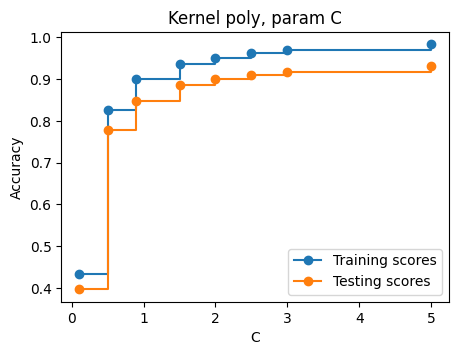

100%|██████████| 8/8 [00:50<00:00,  6.25s/it]


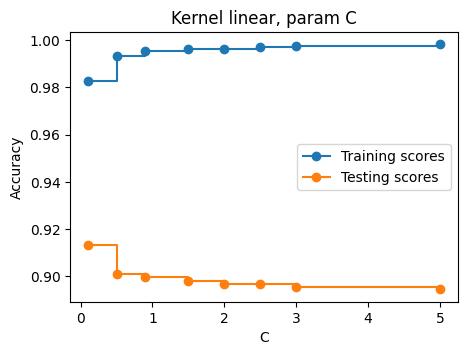

100%|██████████| 8/8 [03:58<00:00, 29.82s/it]


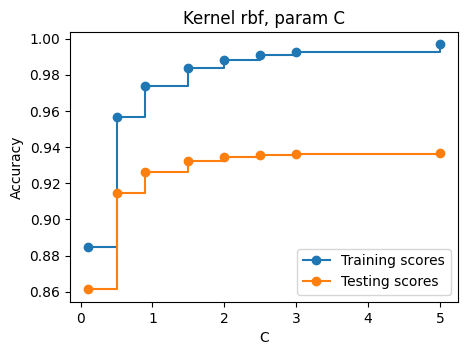

100%|██████████| 8/8 [03:05<00:00, 23.19s/it]


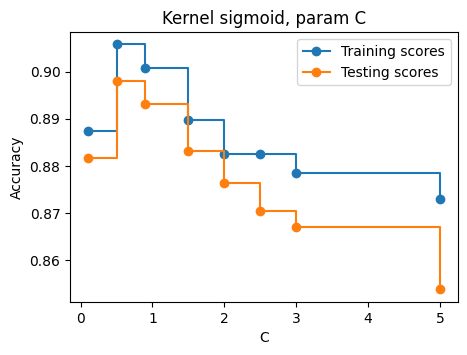

In [6]:
from sklearn.svm import SVC
from tqdm import tqdm


# searching kernel=poly, param=C

paramC = [0.1, 0.5, 0.9, 1.5, 2, 2.5, 3, 5]

trainScores = np.zeros(len(paramC))
testScores = np.zeros(len(paramC))

for i, c in enumerate(tqdm(paramC)):
    m = SVC(kernel='poly', C=c)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel poly, param C", 'C', 'Accuracy', paramC, trainScores, testScores, "Training scores", "Testing scores")


trainScores = np.zeros(len(paramC))
testScores = np.zeros(len(paramC))

for i, c in enumerate(tqdm(paramC)):
    m = SVC(kernel='linear', C=c)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel linear, param C", 'C', 'Accuracy', paramC, trainScores, testScores, "Training scores", "Testing scores")


trainScores = np.zeros(len(paramC))
testScores = np.zeros(len(paramC))

for i, c in enumerate(tqdm(paramC)):
    m = SVC(kernel='rbf', C=c)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel rbf, param C", 'C', 'Accuracy', paramC, trainScores, testScores, "Training scores", "Testing scores")


trainScores = np.zeros(len(paramC))
testScores = np.zeros(len(paramC))

for i, c in enumerate(tqdm(paramC)):
    m = SVC(kernel='sigmoid', C=c)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel sigmoid, param C", 'C', 'Accuracy', paramC, trainScores, testScores, "Training scores", "Testing scores")

#### Findings so far

* It has been observed that C=2 yields the optimal value. Beyond this value, there is not much improvement.
* The linear and sigmoid kernel do not seem to work in this case.

#### Next: tuning polynomial kernel

We are going to work with the polynomial kernel and tune the _degree_ and _gamma_ parameters.

100%|██████████| 6/6 [01:48<00:00, 18.15s/it]


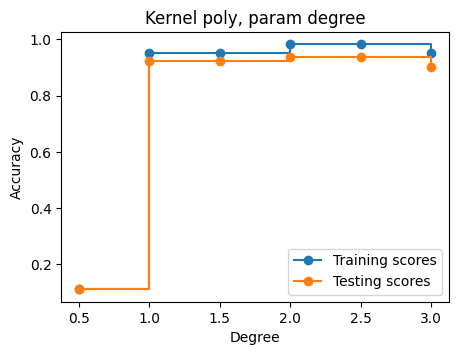

In [7]:
# searching kernel=poly, param=degree

paramDegrees = [0.5, 1, 1.5, 2, 2.5, 3]
trainScores = np.zeros(len(paramDegrees))
testScores = np.zeros(len(paramDegrees))

for i, d in enumerate(tqdm(paramDegrees)):
    m = SVC(kernel='poly', C=2, degree=d)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel poly, param degree", 'Degree', 'Accuracy', paramDegrees, trainScores, testScores, "Training scores", "Testing scores")

100%|██████████| 2/2 [00:28<00:00, 14.19s/it]


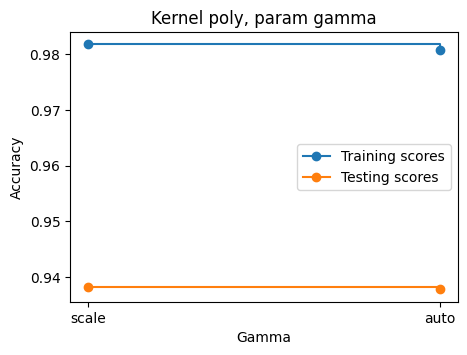

In [8]:
# searching kernel=poly, param=gamma

paramGammas = ['scale', 'auto']
trainScores = np.zeros(len(paramGammas))
testScores = np.zeros(len(paramGammas))

for i, g in enumerate(tqdm(paramGammas)):
    m = SVC(kernel='poly', C=2, degree=2, gamma=g)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel poly, param gamma", 'Gamma', 'Accuracy', paramGammas, trainScores, testScores, "Training scores", "Testing scores")

#### Findings

- Degree 2 is optimal.
- Gamma has no effect.

#### Next: tuning RBF kernel

We are going to tune the gamma parameter.

100%|██████████| 2/2 [01:00<00:00, 30.33s/it]


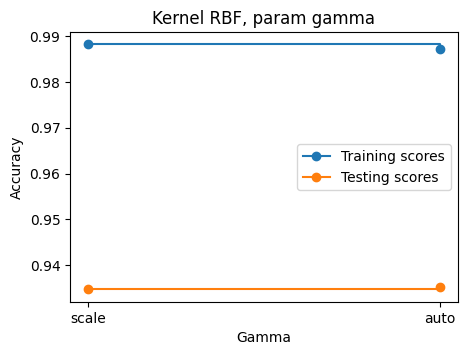

In [9]:
# searching kernel=rbf, param=gamma

paramGammas = ['scale', 'auto']
trainScores = np.zeros(len(paramGammas))
testScores = np.zeros(len(paramGammas))

for i, g in enumerate(tqdm(paramGammas)):
    m = SVC(kernel='rbf', C=2, gamma=g)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Kernel RBF, param gamma", 'Gamma', 'Accuracy', paramGammas, trainScores, testScores, "Training scores", "Testing scores")

#### Finding

There is virtually no difference from the different gamma values.

#### End of part 2

We have discovered 2 configurations of SVM models that performs well on the testing data.

In [11]:
m1 = SVC(kernel='poly', C=2, degree=2).fit(X_train2_std, y_train2)
m2 = SVC(kernel='rbf', C=2).fit(X_train2_std, y_train2)

print(f"SVC with polynomial kernel. Accuracy: { m1.score(X_test2_std, y_test2) }")
print(f"SVC with RBF kernel. Accuracy: { m2.score(X_test2_std, y_test2) }")

SVC with polynomial kernel. Accuracy: 0.9381891891891891
SVC with RBF kernel. Accuracy: 0.9346756756756757
